<h1> Belajar Pengembangan Machine Learning </h1>
<h3> Membuat Model Machine Learning dengan Data Time Series </h3>

Nama : Fatihah Rahmadayana


Dataset Source : https://www.kaggle.com/sudalairajkumar/daily-temperature-of-major-cities

In [1]:
import pandas as pd
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
data = pd.read_csv("/content/drive/My Drive/data/city_temperature.csv")
data = data[data.Region == 'North America']
data = data[data.Country == 'Canada']
data = data[data.City == 'Vancouver']
data.reset_index(drop=True, inplace=True)
data.drop(columns=['Region','Country','State','City'], inplace=True)
data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Month,Day,Year,AvgTemperature
0,1,1,1995,30.3
1,1,2,1995,29.6
2,1,3,1995,29.4
3,1,4,1995,29.2
4,1,5,1995,30.1
...,...,...,...,...
7096,6,6,2014,59.5
7097,6,7,2014,61.1
7098,6,8,2014,63.7
7099,6,9,2014,61.7


In [4]:
data['date'] = pd.to_datetime(data.apply(lambda x:'%s-%s-%s' % (int(x['Year']), int(x['Month']), int(x['Day'])), axis=1))
data.drop(columns=['Year','Month','Day'], inplace=True)
data

,AvgTemperature,date
0,30.3,1995-01-01
1,29.6,1995-01-02
2,29.4,1995-01-03
3,29.2,1995-01-04
4,30.1,1995-01-05
...,...,...
7096,59.5,2014-06-06
7097,61.1,2014-06-07
7098,63.7,2014-06-08
7099,61.7,2014-06-09


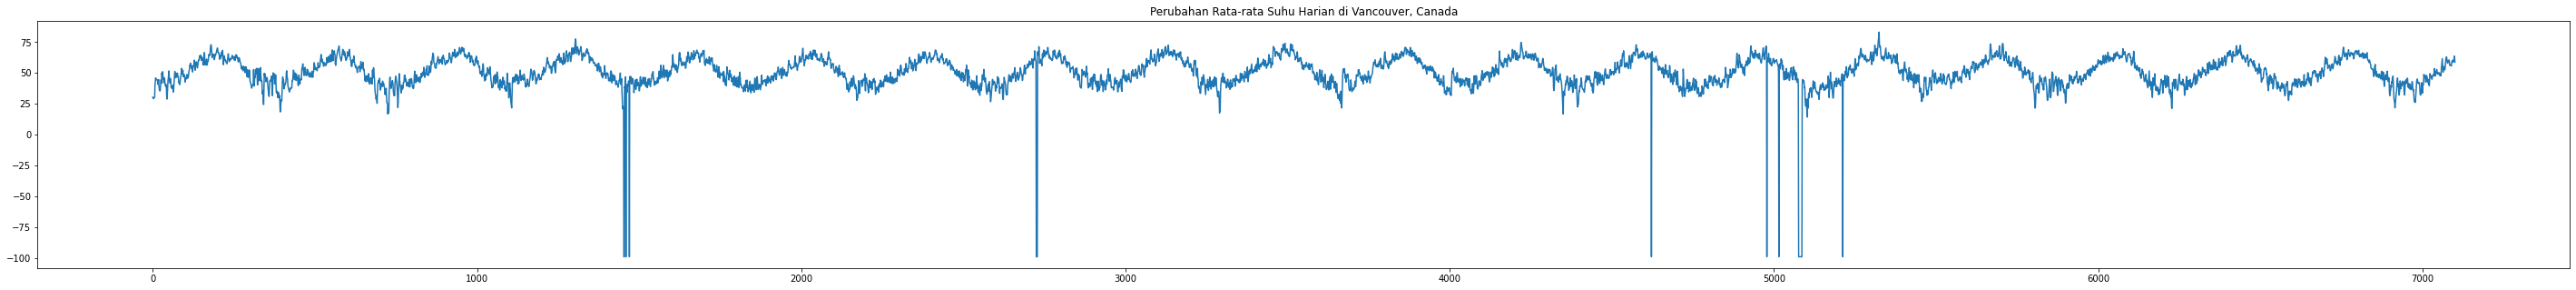

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(50,5))
plt.plot(data['AvgTemperature'])
plt.title('Perubahan Rata-rata Suhu Harian di Vancouver, Canada')
plt.show()

In [11]:
tf.keras.backend.set_floatx('float64')

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
from sklearn.model_selection import train_test_split

X = data['date']
y = data['AvgTemperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
train_set = windowed_dataset(y_train, window_size=64, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(y_test, window_size=64, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [15]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
MAE = (data['AvgTemperature'].max() - data['AvgTemperature'].min()) * 10/100

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<MAE and logs.get('val_mae')<MAE):
      print("\nThe model stops learning, it meets the MAE criteria > 10% of the data scale")
      self.model.stop_training = True
callbacks = myCallback()

In [18]:
model.fit(train_set, epochs = 100, validation_data = test_set, verbose = 1, callbacks=[callbacks])

Epoch 1/100
57/57 [==============================] - 23s 324ms/step - loss: 50.3621 - mae: 50.8621 - val_loss: 50.3280 - val_mae: 50.8280
Epoch 2/100
57/57 [==============================] - 18s 315ms/step - loss: 50.0079 - mae: 50.5079 - val_loss: 49.9692 - val_mae: 50.4692
Epoch 3/100
57/57 [==============================] - 18s 313ms/step - loss: 49.5984 - mae: 50.0984 - val_loss: 49.4635 - val_mae: 49.9635
Epoch 4/100
57/57 [==============================] - 18s 311ms/step - loss: 48.9449 - mae: 49.4449 - val_loss: 48.5969 - val_mae: 49.0969
Epoch 5/100
57/57 [==============================] - 18s 315ms/step - loss: 47.7125 - mae: 48.2125 - val_loss: 46.8134 - val_mae: 47.3134
Epoch 6/100
57/57 [==============================] - 18s 316ms/step - loss: 44.8389 - mae: 45.3389 - val_loss: 42.1160 - val_mae: 42.6160
Epoch 7/100
57/57 [==============================] - 18s 318ms/step - loss: 35.7863 - mae: 36.2861 - val_loss: 25.0203 - val_mae: 25.5195
Epoch 8/100
57/57 [===============